In [4]:
import xarray as xr 
import geopandas as gpd 
import s3fs
import rioxarray # for the extension to load
# import re
import pandas as pd 
import numpy as np
# import logging
import regionmask
import cartopy
import matplotlib.pyplot as plt

# logger = logging.getLogger()
# logging.basicConfig(level="INFO")

In [5]:
# Target variables that we want to extract from the data.zarr
variables = ["TOTAL_NITROGEN","Chl_a_sum","PhyL_Chl","PhyS_Chl","Oxy_sat","MA_N_pr","Secchi","Kd_490","DOR_P","DOR_N","DOR_C","salt","temp","TN","TC","TP"]

# Selecting the depth index grather or equal to 13 equivalent to depth from -5.55m to surface
target_depth_min = 13
target_depth_max = 17

# 1. Extract Reef's shapefile from DMS and create the global polygon

In [6]:
# DMS reef shape path
reefshape_path = 's3://gbr-dms-data-public/gbrmpa-complete-gbr-features/data.parquet'
# Connecting to the S3 bucket where the GBR data is stored
reefshape = gpd.read_parquet(reefshape_path,
                            #Specifying which columns to read
                            columns = ['UNIQUE_ID', 'GBR_NAME', 'LOC_NAME_S', 'LEVEL_1', 'geometry'],
                            #Connecting anonimously as no authentication is needed for this s3 bucket (it is public)
                            storage_options = {"anon": True}) 

# # Filtering the data to only include the Reef type
reefshape = reefshape[reefshape['LEVEL_1'] == 'Reef']

# Dropping duplicates based on the UNIQUE_ID column
reefshape.drop_duplicates(subset=['LOC_NAME_S'], inplace=True)
reefshape = reefshape.to_crs("EPSG:4326")
reefshape

,UNIQUE_ID,GBR_NAME,LOC_NAME_S,LEVEL_1,geometry
fid,,,,,
459,09361104104,U/N Reef,U/N Reef (09-361d),Reef,"POLYGON ((143.22825 -9.2641, 143.22802 -9.2641..."
460,09361104100,U/N Reef,U/N Reef (09-361),Reef,"POLYGON ((143.23613 -9.26759, 143.23502 -9.267..."
461,09361104102,U/N Reef,U/N Reef (09-361b),Reef,"POLYGON ((143.23517 -9.26074, 143.23577 -9.261..."
462,09361104103,U/N Reef,U/N Reef (09-361c),Reef,"POLYGON ((143.228 -9.26056, 143.2274 -9.26077,..."
463,09361104105,U/N Reef,U/N Reef (09-361e),Reef,"POLYGON ((143.21933 -9.25797, 143.21873 -9.257..."
...,...,...,...,...,...
9601,10510109102,Mainland,Mainland (10-510b),Reef,"POLYGON ((142.39805 -10.803, 142.39708 -10.802..."
9602,10510109103,Mainland,Mainland (10-510c),Reef,"POLYGON ((142.36692 -10.84571, 142.3666 -10.84..."
9609,10258106100,Quetta Rock,Quetta Rock (10-258),Reef,"POLYGON ((142.62941 -10.67, 142.62927 -10.6696..."


In [5]:
len(reefshape.UNIQUE_ID.unique())

7053

## Creating single polygon for Great Barrier Reef

In [7]:
gbreefD = reefshape.dissolve()

## Plotting GBR map 

<Axes: >

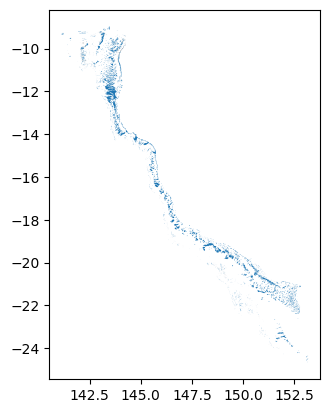

In [7]:
gbreefD.plot()

# 2. Extract source variables from DMS eReef zarr
Refer to the [original metadata]( https://eatlas.org.au/geonetwork/srv/eng/catalog.search#/metadata/61f3a6df-2c4a-46b6-ab62-3f3a9bf4e87a)

In [8]:
%%time
zarr_path = "s3://gbr-dms-data-public/aims-ereefs-biogeochem-baseline-daily-monthly/data.zarr/"

fs = s3fs.S3FileSystem(anon=True)

data = xr.open_zarr(s3fs.S3Map(zarr_path, s3=fs), 
                    #chunks = {'time':300,'k':4,'latitude':120,'longitude':100}, 
                    consolidated=True)

# Selecting the depth index grather or equal to 13 equivalent to depth from -5.55m to surface

data = data.sel(k=slice(target_depth_min, target_depth_max))

data = data[variables]
data

CPU times: user 5.4 s, sys: 1.65 s, total: 7.04 s
Wall time: 46.1 s


<xarray.Dataset> Size: 253GB
Dimensions:         (time: 3073, k: 4, latitude: 723, longitude: 491)
Coordinates:
  * latitude        (latitude) float64 6kB -28.7 -28.67 -28.64 ... -7.066 -7.036
  * longitude       (longitude) float64 4kB 142.2 142.2 142.2 ... 156.8 156.9
  * time            (time) datetime64[ns] 25kB 2010-12-01T02:00:00 ... 2019-0...
    zc              (k) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>
Dimensions without coordinates: k
Data variables: (12/16)
    TOTAL_NITROGEN  (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    Chl_a_sum       (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    PhyL_Chl        (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    PhyS_Chl        (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    Oxy_sat         (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    MA_N_pr         (time, latitude, longitude) float32 4GB dask.array<chunksize=(1, 723, 491), meta=np.ndarray>
    ...              ...
    DOR_C           (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    salt            (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    temp            (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    TN              (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    TC              (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    TP              (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                   CF-1.0
    NCO:                           netCDF Operators version 4.7.7 (Homepage =...
    RunID:                         2
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:    2021-09-07T21:05:18+10:00
    aims_ncaggregate_datasetId:    products__ncaggregate__ereefs__GBR4_H2p0_B...
    ...                            ...
    metadata_link:                 https://eatlas.org.au/data/uuid/61f3a6df-2...
    paramfile:                     /home/bai155/EMS_solar2/gbr4_H2p0_B3p1_Cb/...
    paramhead:                     eReefs 4 km grid. SOURCE Catchments with 2...
    technical_guide_link:          https://eatlas.org.au/pydio/public/aims-er...
    technical_guide_publish_date:  2020-08-18
    title:                         eReefs AIMS-CSIRO GBR4 BioGeoChemical 3.1 ...

In [9]:
%%time
reef_sample = data
reef_sample.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

reef_sample.rio.write_crs("epsg:4326", inplace=True)
data_clipped = reef_sample.rio.clip(gbreefD.geometry.values, gbreefD.crs, drop=True,all_touched=True)

data_clipped

CPU times: user 14.9 s, sys: 116 ms, total: 15 s
Wall time: 15.1 s


<xarray.Dataset> Size: 138GB
Dimensions:         (latitude: 525, longitude: 368, time: 3073, k: 4)
Coordinates:
  * latitude        (latitude) float64 4kB -24.68 -24.65 ... -8.986 -8.956
  * longitude       (longitude) float64 3kB 142.2 142.2 142.2 ... 153.1 153.2
  * time            (time) datetime64[ns] 25kB 2010-12-01T02:00:00 ... 2019-0...
    zc              (k) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>
    spatial_ref     int64 8B 0
Dimensions without coordinates: k
Data variables: (12/16)
    TOTAL_NITROGEN  (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    Chl_a_sum       (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    PhyL_Chl        (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    PhyS_Chl        (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    Oxy_sat         (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    MA_N_pr         (time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 525, 368), meta=np.ndarray>
    ...              ...
    DOR_C           (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    salt            (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    temp            (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    TN              (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    TC              (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    TP              (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                   CF-1.0
    NCO:                           netCDF Operators version 4.7.7 (Homepage =...
    RunID:                         2
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:    2021-09-07T21:05:18+10:00
    aims_ncaggregate_datasetId:    products__ncaggregate__ereefs__GBR4_H2p0_B...
    ...                            ...
    metadata_link:                 https://eatlas.org.au/data/uuid/61f3a6df-2...
    paramfile:                     /home/bai155/EMS_solar2/gbr4_H2p0_B3p1_Cb/...
    paramhead:                     eReefs 4 km grid. SOURCE Catchments with 2...
    technical_guide_link:          https://eatlas.org.au/pydio/public/aims-er...
    technical_guide_publish_date:  2020-08-18
    title:                         eReefs AIMS-CSIRO GBR4 BioGeoChemical 3.1 ...

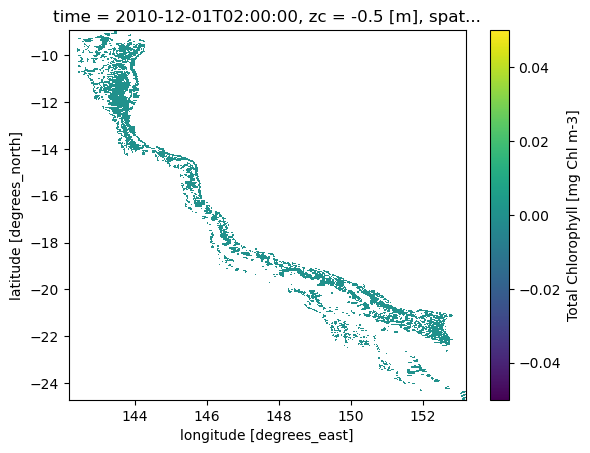

In [10]:
data_clipped.Chl_a_sum.isel(time=0,k=3).plot()

# Reclipping data

In [10]:
RS103=reefshape[reefshape['UNIQUE_ID'] =='16026100104']
RS103

,UNIQUE_ID,GBR_NAME,LOC_NAME_S,LEVEL_1,geometry
fid,,,,,
4757,16026100104,Tongue Reef,Tongue Reef (16-026),Reef,"POLYGON ((145.64465 -16.25114, 145.64663 -16.2..."


In [15]:
%%time
#with chunking
data_clipped_chunked = data_clipped.chunk({'time':300,'latitude':50,'longitude':30,'k':4})


CPU times: user 2.6 s, sys: 27.2 ms, total: 2.62 s
Wall time: 2.78 s


In [16]:
%%time
#with chunking
data_reef103=data_clipped_chunked.rio.clip(RS103.geometry.values, gbreefD.crs, drop=True,all_touched=True)

CPU times: user 259 ms, sys: 27.1 ms, total: 286 ms
Wall time: 322 ms


In [17]:
%%time
#without chunking
data_reef103=data_clipped.rio.clip(RS103.geometry.values, gbreefD.crs, drop=True,all_touched=True)

CPU times: user 283 ms, sys: 20.2 ms, total: 303 ms
Wall time: 322 ms


In [13]:
test = data_reef103.temp.isel(k = 0)

In [14]:
test

<xarray.DataArray 'temp' (time: 3073, latitude: 6, longitude: 10)> Size: 738kB
dask.array<getitem, shape=(3073, 6, 10), dtype=float32, chunksize=(1, 6, 10), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 48B -16.4 -16.37 -16.34 -16.31 -16.28 -16.25
  * longitude    (longitude) float64 80B 145.6 145.7 145.7 ... 145.9 145.9 145.9
  * time         (time) datetime64[ns] 25kB 2010-12-01T02:00:00 ... 2019-04-3...
    zc           float64 8B dask.array<chunksize=(), meta=np.ndarray>
    spatial_ref  int64 8B 0
Attributes:
    long_name:   Temperature
    short_name:  temp
    units:       degrees C

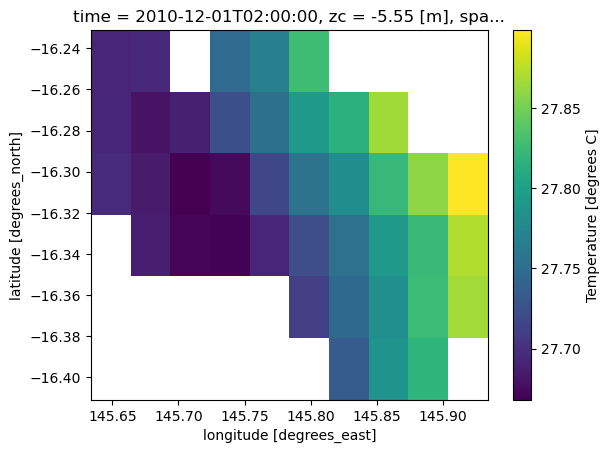

In [15]:
test.isel(time = 0).plot()

In [18]:
%%time
reef_indiv={}
count = 0
for i in reefshape['UNIQUE_ID'][:100]:
    reef_i = reefshape[reefshape['UNIQUE_ID'] ==i]
    reef_data_i = data_clipped.rio.clip(reef_i.geometry.values, reef_i.crs, drop=True,all_touched=True)
    reef_indiv[i]=reef_data_i
    count = count+1
    #print(count)

CPU times: user 38 s, sys: 2.41 s, total: 40.4 s
Wall time: 43.4 s


In [19]:
%%time
reef_indiv={}
count = 0
for i in reefshape['UNIQUE_ID'][:100]:
    reef_i = reefshape[reefshape['UNIQUE_ID'] ==i]
    reef_data_i = data_clipped_chunked.rio.clip(reef_i.geometry.values, reef_i.crs, drop=True,all_touched=True)
    reef_indiv[i]=reef_data_i
    count = count+1
    #print(count)

CPU times: user 22.8 s, sys: 1.55 s, total: 24.4 s
Wall time: 26.5 s


In [18]:
reef_indiv

{'09361104104': <xarray.Dataset> Size: 738kB
 Dimensions:         (latitude: 1, longitude: 1, time: 3073, k: 4)
 Coordinates:
   * latitude        (latitude) float64 8B -9.256
   * longitude       (longitude) float64 8B 143.2
   * time            (time) datetime64[ns] 25kB 2010-12-01T02:00:00 ... 2019-0...
     zc              (k) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>
     spatial_ref     int64 8B 0
 Dimensions without coordinates: k
 Data variables: (12/16)
     TOTAL_NITROGEN  (time, k, latitude, longitude) float32 49kB dask.array<chunksize=(1, 4, 1, 1), meta=np.ndarray>
     Chl_a_sum       (time, k, latitude, longitude) float32 49kB dask.array<chunksize=(1, 4, 1, 1), meta=np.ndarray>
     PhyL_Chl        (time, k, latitude, longitude) float32 49kB dask.array<chunksize=(1, 4, 1, 1), meta=np.ndarray>
     PhyS_Chl        (time, k, latitude, longitude) float32 49kB dask.array<chunksize=(1, 4, 1, 1), meta=np.ndarray>
     Oxy_sat         (time, k, latitude, longitude)